# ODS – Etapa 2 (Clasificación de texto)
El objetivo de este trabajo es clasificar opiniones ciudadanas en relación con los Objetivos de Desarrollo Sostenible (ODS) 1, 3 y 4 mediante modelos de aprendizaje supervisado.  
- **ODS 1:** Fin de la pobreza  
- **ODS 3:** Salud y bienestar  
- **ODS 4:** Educación de calidad  


Estructura:
1) Entendimiento de los datos
2) Procesamiento de datos
3) Modelos (vistos y no vistos en clase)
4) Ajuste de hiperparámetros
5) Modelo Final
6) Interpretación de resultados
7) Exportación de predicciones 

## 1. Entendimiento de Datos

### 1.1 Imports y configuración

En esta sección se cargan las librerías necesarias para el proyecto.  
- **pandas, numpy y matplotlib**: herramientas base para manipulación de datos y visualización.  
- **scikit-learn**: librería principal para machine learning, desde donde se importan módulos para:
  - **Preprocesamiento**: TfidfVectorizer para convertir textos en vectores numéricos.  
  - **Modelado**: SVC  
  - **Evaluación**: train_test_split, GridSearchCV, StratifiedKFold, métricas y visualización de la matriz de confusión.  
  - **Feature selection**: chi2 para selección estadística de variables.  
- **joblib**: para exportar el modelo final entrenado.  

Además, se establecen parámetros de estilo para las gráficas y se fija una semilla aleatoria `RANDOM_STATE = 42` con el fin de garantizar reproducibilidad de los resultados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import chi2
from joblib import dump

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # Buena practica para reproducibilidad


### 1.2 Carga de datos

Los datos provienen de archivos en formato XLS:

Cada registro tiene dos columnas principales:  
- **textos**: la opinión ciudadana en lenguaje natural.  
- **labels**: la etiqueta correspondiente al ODS asociado (1 = Fin de la pobreza, 3 = Salud y bienestar, 4 = Educación de calidad).

Se realiza:  
1. Lectura de los archivos Excel.  
2. Selección de las columnas relevantes. 
3. Se dejan los datos de la etapa 1 para entrenamiento, y los de la etapa 2 netamente para la validación entre el modelo de la etapa 1 y el modelo reentrenado con prompting.
4. Visualización de las primeras instancias para confirmar la correcta importación.

In [2]:
DATA_PATH_1   = "Datos_proyecto.xlsx"  
DATA_PATH_2   = "Datos_etapa 2.xlsx"  
DATA_PATH_TEST = "Datos de prueba_proyecto.xlsx"        
TEXT_COL    = "textos"                       
LABEL_COL   = "labels"

xls1 = pd.ExcelFile(DATA_PATH_1)
xls2 = pd.ExcelFile(DATA_PATH_2)
print("Hojas:", xls1.sheet_names)

df = pd.read_excel(DATA_PATH_1, sheet_name=xls1.sheet_names[0])
df_validacion = pd.read_excel(DATA_PATH_2, sheet_name=xls2.sheet_names[0])
df = df[[TEXT_COL, LABEL_COL]].rename(columns={TEXT_COL:"textos", LABEL_COL:"labels"})
test_data= pd.read_excel(DATA_PATH_TEST)
df.head(10)

Hojas: ['Sheet1']


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
5,Los datos a nivel del sistema que no se deriva...,4
6,La principal ventaja de las evaluaciones exter...,4
7,Los pacientes pueden elegir a cualquier médico...,3
8,"De hecho, es probable que la designación de la...",4
9,"De hecho, aunque Chile y Uruguay tienen índice...",1


### 1.3 Entendimiento de los datos

En esta sección realizamos un perfilamiento rápido del dataset para validar su estructura y conocer el comportamiento básico de los textos y las etiquetas (ODS). En particular:

- **Estructura y tipos**: dimensiones del dataset, columnas y tipos de dato.
- **Longitud de textos**: cálculo del numero de palabras y caracteres por opinión; estadísticos descriptivos.
- **Distribuciones**: histogramas y boxplots para identificar sesgos y posibles outliers.
- **Etiquetas (ODS)**: conteos y proporciones por clase para detectar desbalance.

Este diagnóstico guía las decisiones de **preparación** (limpieza, normalización, vectorización) y **evaluación** (métricas y validación estratificada) en el modelado.

In [3]:
print("Dimensiones:", df.shape)
display(df.info())

Dimensiones: (2424, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


None

In [4]:
# Longitud de textos
df["len_words"] = df["textos"].astype(str).str.split().str.len()
df["len_chars"] = df["textos"].astype(str).str.len()
df[["len_words","len_chars"]].describe().T

,count,mean,std,min,25%,50%,75%,max
len_words,2424.0,107.924092,35.575349,41.0,81.0,102.0,129.00,260.0
len_chars,2424.0,683.223185,223.563695,303.0,513.0,647.0,809.25,1492.0


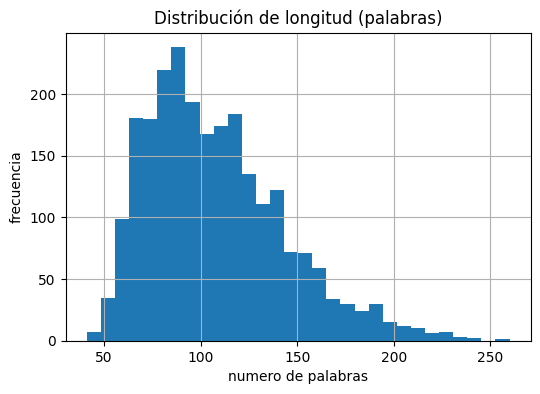

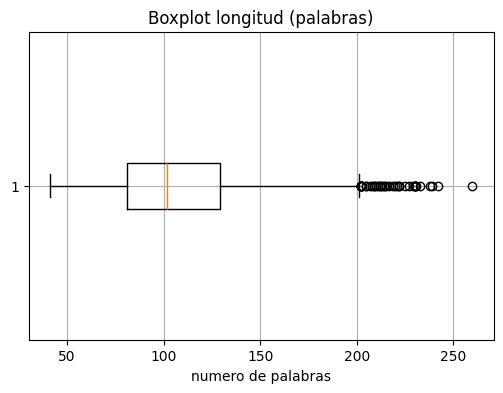

In [5]:
# Histograma longitudes (palabras)
fig, ax = plt.subplots()
ax.hist(df["len_words"], bins=30)
ax.set_title("Distribución de longitud (palabras)")
ax.set_xlabel("numero de palabras"); ax.set_ylabel("frecuencia")
plt.show()

# Boxplot para outliers
fig, ax = plt.subplots()
ax.boxplot(df["len_words"], vert=False)
ax.set_title("Boxplot longitud (palabras)")
ax.set_xlabel("numero de palabras")
plt.show()

labels
4    1025
3     894
1     505
Name: count, dtype: int64

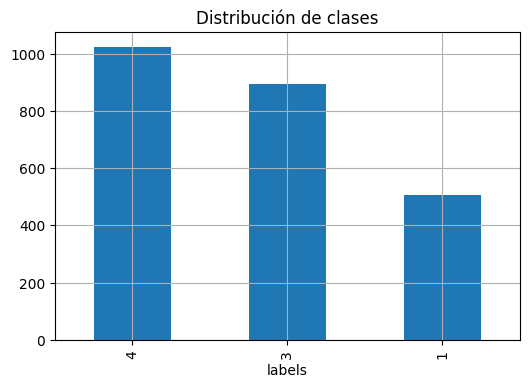

In [6]:
# Distribución de las clases
counts = df["labels"].value_counts()
counts.plot.bar(title="Distribución de clases")
counts


**Interpretacion del entendimiento de datos**

- Dataset con **2,424 registros** y **2 columnas** textos y labels, sin valores nulos.  
- Opiniones con longitud media de **108 palabras** y **683 caracteres**; se observan textos muy extensos pero no afectan el análisis inicial.  
- Distribución de etiquetas: ODS 4 = 1,025; ODS 3 = 894; ODS 1 = 505 → existe **desbalance moderado**, especialmente en ODS 1. 
- Decisiones: Hacemos prompting para nivelar las clases (esto esta en procesamiento de datos)


### 1.4 Revisión Calidad de datos

Evaluamos 4 dimensiones prácticas para texto:
1) **Completitud**: NA, vacíos, mínimos de longitud.
2) **Unicidad**: duplicados por textos y por textos+labels.
3) **Validez/Consistencia**: esquema esperado y dominio de labels: 1,3,4.
4) **Ruido/Outliers**: textos extremadamente largos/cortos y señales de ruido.

In [7]:
# 1) Completitud
print("Completitud")
na = df.isna().sum()
print("Cantidad de cols con NA:", na.sum())
empty = (df["textos"].astype(str).str.strip()=="").sum()
print("Cantidad de cols vacías:", empty)

# 2) Unicidad
print("\nUnicidad")
dup_text = df.duplicated(subset=["textos"]).sum()
print("Cantidad de textos duplicados:", dup_text)
dup_both = df.duplicated(subset=["textos","labels"]).sum()
print("Cantidad de filas duplicadas:", dup_both)

# 3) Validez / Consistencia
print("\nValidez / Consistencia")
cols_ok = set(df.columns) == {"textos","labels","len_words","len_chars"}
print("Columnas correctas en todo el DataFrame:", cols_ok)
labels_ok = set(df["labels"].unique()) <= {1,3,4}
print("Etiquetas correctas en todo el DataFrame:", labels_ok)

# 4) Ruido / Outliers
print("\nRuido / Outliers")
alpha = df["textos"].astype(str).apply(lambda s: sum(ch.isalpha() for ch in s)/max(1,len(s)))
pct_ruido = (alpha<0.6).mean()
print("Porcentaje de textos con menos del 60% de caracteres alfabéticos:", pct_ruido)
p75, p95, pmax = df["len_words"].quantile([.75, .95, 1.0])
print("Percentil 75, 95 y maximo de longitud (palabras):", p75, p95, pmax)

Completitud
Cantidad de cols con NA: 0
Cantidad de cols vacías: 0

Unicidad
Cantidad de textos duplicados: 0
Cantidad de filas duplicadas: 0

Validez / Consistencia
Columnas correctas en todo el DataFrame: True
Etiquetas correctas en todo el DataFrame: True

Ruido / Outliers
Porcentaje de textos con menos del 60% de caracteres alfabéticos: 0.0
Percentil 75, 95 y maximo de longitud (palabras): 129.0 177.0 260.0


**Intepretación de la calidad de datos**

- **Completitud:** no se encontraron valores nulos ni textos vacíos; todos cumplen el mínimo de 3 palabras.  
- **Unicidad:** no hay duplicados ni por textos ni por textos+labels.  
- **Validez/Consistencia:** el esquema de columnas es el esperado y las etiquetas pertenecen al dominio correcto: 1, 3, 4.  
- **Ruido/Outliers:** 0% de textos con baja proporción alfabética; las longitudes muestran cola derecha con máximos de 260 palabras (esperables en opiniones extensas).  

En general, la base presenta alta calidad: completa, sin duplicados y con etiquetas válidas. Solo se documentan outliers largos, que no afectan el entrenamiento inicial.

## 2. Preparación de datos

Para entrenar modelos de clasificación de texto se realizaron tres pasos:

1. **Balanceo de etiquetas**: Se realiza la aumentación usando IA generativa.
2. **Normalización y estandarización**: limpieza de caracteres, minúsculas, tokenización, eliminación de stopwords en español y stemming.  
3. **Split de datos**: división en entrenamiento, y prueba.  
4. **Vectorización TF-IDF**: transformación de textos a representaciones numéricas considerando unigramas y bigramas, con filtros de frecuencia mínima y máxima.

### 1. Balanceo de etiquetas
**Pasos:**
1. Validación de dependencias y conectividad
2. Generación de datos sintéticos
3. Revisión del consumo de tokens

In [8]:
from dotenv import load_dotenv
load_dotenv()

# Validación de dependencias
print("\nValidación de dependencias")
import sys, site, platform, os
secret = os.getenv("OPENAI_API_KEY")
print("API Key:", "OK" if secret and len(secret)>20 else "MISSING")
print("Python exe:", sys.executable)
print("Version:", sys.version)
print("Site-packages:", site.getsitepackages() if hasattr(site,"getsitepackages") else site.getusersitepackages())
print("OS:", platform.platform())

## Dependencias
import os
from openai import OpenAI
import pandas as pd, random

# Validación de conectividad
client = OpenAI(api_key=secret)
models = client.models.list()
print("OK SDK v1.x, modelos:", len(models.data))



Validación de dependencias
API Key: OK
Python exe: c:\Users\Lila\AppData\Local\Programs\Python\Python313\python.exe
Version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Site-packages: ['c:\\Users\\Lila\\AppData\\Local\\Programs\\Python\\Python313', 'c:\\Users\\Lila\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages']
OS: Windows-11-10.0.26100-SP0
OK SDK v1.x, modelos: 96


In [9]:
## Filtrar la clase minoritaria
TEXTO = "textos"
ODS = "labels"
minoritaria = df[ODS].value_counts().idxmin()
# Nota: usamos min(8, ...) para limitar ejemplos de contexto: 8 da diversidad sin gastar muchos tokens;
# si la clase tiene <8 instancias, se toman todas. Ajustar 8->otro número si se quiere más/menos señal.
semillas = (
    df[df[ODS]==minoritaria][TEXTO]
      .dropna()
      .astype(str)
      .sample(
          min(8, sum(df[ODS]==minoritaria)),  # límite ligero de ejemplos de contexto
          random_state=42
      )
      .tolist()
)
ejemplos = "\n".join(f"- {s}" for s in semillas)

# columnas clave
cols = ["textos", "labels"]

# 1) snapshot de lo que ya había
df_before = df[cols].drop_duplicates().copy()
print("La clase minoritaria es:", minoritaria)
print("Filas totales ahora:", len(df))

La clase minoritaria es: 1
Filas totales ahora: 2424


In [10]:
# Cálculo recomendado de cuántos ejemplos sintéticos generar 
import math
counts_actual = df['labels'].value_counts()
count_max = counts_actual.max()
count_min = counts_actual.min()
deficit = count_max - count_min
f = 0.7   # fracción del desbalance a cubrir
s = 0.25  # proporción máxima deseada de textos sintéticos sobre el total final
n_total = len(df)
max_por_share = math.floor((s * n_total) / (1 - s))  
# Cantidad recomendada a generar 
a_generar = min(math.ceil(deficit * f), max_por_share)
print(f"Déficit: {deficit} | Objetivo parcial (f={f}): {math.ceil(deficit*f)} | Límite share: {max_por_share} | Recomendado generar: {a_generar}")
# Nota: si se han agregado sintéticos antes, reducir f o recalcular tras la nueva distribución.


Déficit: 520 | Objetivo parcial (f=0.7): 364 | Límite share: 808 | Recomendado generar: 364


In [11]:
# Prompt: pedirle al modelo que genere datos sintéticos (opiniones ODS)
prompt = f"""
Genera EXACTAMENTE {20} opiniones sintéticas (ODS {minoritaria}) en español Colombia.
Longitud: 12-38 palabras, 1–2 oraciones naturales. Sin listas, sin encabezados.
Diversidad: rota zona (urbano/rural/periurbano), actor (familias, docentes, jóvenes, centros de salud), enfoque (problema, recurso, acceso, impacto) y consecuencia (bienestar, continuidad escolar, inserción laboral, prevención).
Reglas:
- "labels" siempre {minoritaria}
- No repetir >5 palabras seguidas entre textos
- No datos personales, ni política partidista, ni salud sensible específica
- No citar la palabra ODS ni copiar semillas
Semillas (NO copiar literal):
{ejemplos if 'ejemplos' in globals() and ejemplos else '- (sin semillas)'}
Formato: SOLO un array JSON de objetos {{"textos": "...", "labels": {minoritaria}}}
Si no puedes cumplir todas las reglas, devuelve [{{"error":"spec_violation"}}]
""" 

In [12]:
response = client.chat.completions.create(
    model="gpt-4o-mini", # No se debe cambiar este modelo.
    messages=[
        {"role": "system", "content": "Eres un generador de datos sintéticos."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.7
)

In [13]:
import json, pandas as pd, os

raw = response.choices[0].message.content
# Permite que venga envuelto en bloques de markdown
txt = raw.strip()
if txt.startswith("```"):
    txt = txt.strip("`")
    if "\n" in txt:
        txt = txt.split("\n", 1)[1]

data = json.loads(txt)  # debe ser una lista de dicts {"opinion":..., "ods":...}
df_new = pd.DataFrame(data)

df = pd.concat([df, df_new[["textos", "labels"]]], ignore_index=True)
print("Filas totales ahora:", len(df))


Filas totales ahora: 2444


In [14]:

# 2) normaliza lo generado y concatena
df_new = df_new.rename(columns={"opinion": "texto"})[cols].copy()
df = pd.concat([df, df_new], ignore_index=True).drop_duplicates(subset=cols).reset_index(drop=True)

# 3) filas que están en df (nuevo) pero no estaban antes
added_rows = (
    df.merge(df_before, on=cols, how="left", indicator=True)
      .loc[lambda x: x["_merge"] == "left_only", cols]
)

print(f"Nuevas filas agregadas: {len(added_rows)}")
# En notebook, puedes mostrar todas o una vista rápida:
display(added_rows)         
# print(added_rows.to_string(index=False))  # texto plano


Nuevas filas agregadas: 20


,textos,labels
2424,"En las zonas rurales, la falta de oportunidade...",1
2425,Las familias en áreas periurbanas enfrentan se...,1
2426,Los docentes en las ciudades sienten que la fa...,1
2427,La pobreza en núcleos familiares grandes agrav...,1
2428,Los centros de salud en zonas rurales carecen ...,1
2429,La brecha educativa entre zonas urbanas y rura...,1
2430,Los padres solteros en áreas urbanas luchan pa...,1
2431,El acceso a programas de capacitación laboral ...,1
2432,La falta de infraestructura en las zonas rural...,1
2433,Los jóvenes en las zonas periurbanas sienten q...,1


In [15]:
# Mostramos la información de uso
print(f"Tokens usados en el prompt: {response.usage.prompt_tokens}")
print(f"Tokens usados en la respuesta: {response.usage.completion_tokens}")
print(f"Tokens usados en total: {response.usage.total_tokens}")

Tokens usados en el prompt: 1216
Tokens usados en la respuesta: 795
Tokens usados en total: 2011


<Axes: title={'center': 'Distribución de clases tras agregar datos sintéticos'}, xlabel='labels'>

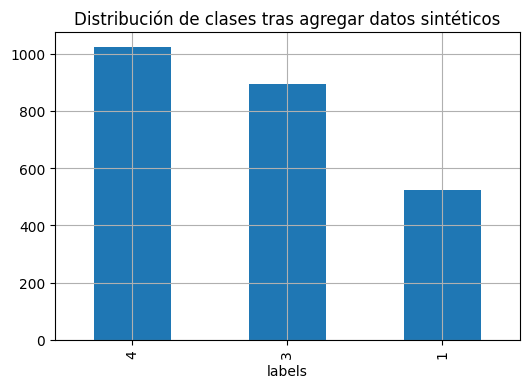

In [16]:
df["labels"].value_counts().plot.bar(title="Distribución de clases tras agregar datos sintéticos")

### 2. Normalización y estandarización: 
Limpieza de caracteres, minúsculas, tokenización, eliminación de stopwords en español y stemming.  

In [17]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
spanish_stopwords = stopwords.words("spanish")


wpt = WordPunctTokenizer()
ps = SnowballStemmer("spanish")
spanish_stopwords = set(stopwords.words("spanish"))

def normalize_text(doc):
    # Limpieza de caracteres
    doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)
    doc = doc.lower().strip()
    
    # Tokenización
    tokens = wpt.tokenize(doc)
    
    # Quitar stopwords + stemming
    filtered_tokens = [ps.stem(token) for token in tokens if token not in spanish_stopwords]
    
    return ' '.join(filtered_tokens)

# Aplicar a todo el DataFrame
normalize_data = np.vectorize(normalize_text)
norm_data = normalize_data(df["textos"].astype(str))

def norm_all_data (data):
    normalize_data = np.vectorize(normalize_text)
    norm_data = normalize_data(data.astype(str))
    return norm_data


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Lila\AppData\Local\Temp\ipykernel_40696\2574022093.py:18: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Las stopwords en español nos permiten eliminar palabras muy comunes (como “de”, “la”, “que”), que no aportan valor a la clasificación. De esta forma el modelo se concentra en términos más relevantes para diferenciar entre los ODS. Esto es coherente con el entendimiento previo, donde identificamos vocabulario repetitivo que podía introducir ruido.

Se aplica normalización (minúsculas, limpieza de caracteres) y stemming, junto con tokenización y eliminación de stopwords. Esto asegura que textos con la misma raíz (e.g. “educar”, “educación”) se procesen como equivalentes, reduciendo variabilidad innecesaria y facilitando que el modelo capture patrones claros.

### 3. Division en test y train
En este caso como no vamos a usar otros modelos aparte de SVM no es necesario ddatos de validación

In [18]:
#Split de datos de entrenamiento y prueba (80%, 20%) 
X = norm_data
y = df["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)


### 4. Vectorización TF-IDF
Transformación de textos a representaciones numéricas considerando unigramas y bigramas, con filtros de frecuencia mínima y máxima.

In [19]:
# Vectorización TF-IDF, eso es Term Frequency–Inverse Document Frequency (lo vimos en clase)
# Entonces las palabras que aparecen en muchos documentos (alta frecuencia) tienen menos peso
# y las que aparecen en pocos documentos (baja frecuencia) tienen más peso
# Después de la búsqueda de hiperparámetros en etapa 1, los mejores params: { 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}

tfidf = TfidfVectorizer(
    strip_accents="unicode",
    token_pattern=r"(?u)\b\w\w+\b",   
    ngram_range=(1,2),
    min_df=2,
    max_df=0.85
)

**En resumen:**
- Se creó un pipeline de normalización que asegura textos homogéneos y enfocados en palabras relevantes (ej. salud, educación, pobreza).  
- Los datos fueron divididos en entrenamiento (80%) y prueba (10%). 
- La vectorización TF-IDF generó un espacio de 13,057 características, capturando unigramas y bigramas, ademas, se filtraron términos muy raros o demasiado frecuentes.  
- Este conjunto procesado está listo para la fase de modelado y evaluación.


## 3. Reentrenamiento del mejor modelo de la etapa 1 : Linear SVM 

Fitting 5 folds for each of 96 candidates, totalling 480 fits


C:\Users\Lila\AppData\Local\Temp\ipykernel_40696\2574022093.py:18: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


Mejores params: {'svm__C': 1.0, 'svm__class_weight': 'balanced', 'svm__loss': 'hinge', 'tfidf__max_df': 0.85, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Mejor F1 macro: 0.97


C:\Users\Lila\AppData\Local\Temp\ipykernel_40696\2574022093.py:18: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)



 SVM (mejor grid) en datos de validación 

              precision    recall  f1-score   support

           1      0.971     0.943     0.957       105
           3      0.967     0.978     0.972       179
           4      0.985     0.990     0.988       205

    accuracy                          0.975       489
   macro avg      0.974     0.970     0.972       489
weighted avg      0.975     0.975     0.975       489



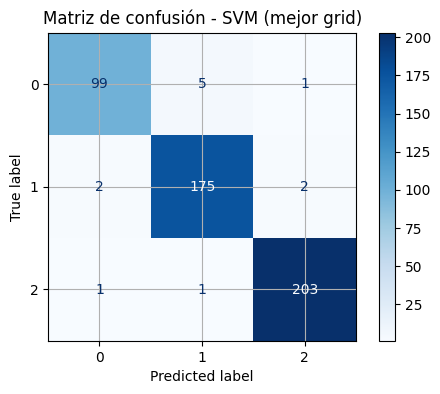

,steps,"[('normalize', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function nor...0018882508720>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [20]:
#Creamos un pipeline para encapsular el proceso de vectorización y el modelo linear SVM
from sklearn.pipeline import FunctionTransformer
from sklearn.svm import LinearSVC
import joblib

pipeSVM = Pipeline([
    ("normalize", FunctionTransformer(norm_all_data)),
    ("tfidf", tfidf),
    ("svm", LinearSVC())
])

# Definimos el grid de hiperparámetros para SVM
param_grid_svm = {
    "svm__C": [0.1, 1.0, 10.0],
    "svm__loss": ["hinge", "squared_hinge"],
    "svm__class_weight": [None, "balanced"],

    "tfidf__min_df": [2, 3],
    "tfidf__max_df": [0.85, 0.9],
    "tfidf__ngram_range": [(1,1),(1,2)]
    
}

# Configuramos el GridSearchCV para SVM
grid_svm = GridSearchCV(pipeSVM, param_grid_svm, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_svm.fit(X_train, y_train)

# Obtenemos el mejor pipeline
mejor_pipe_svm = grid_svm.best_estimator_
print("Mejores params:", grid_svm.best_params_)
print("Mejor F1 macro:", round(grid_svm.best_score_, 2))

# Evaluación en Val, esto no visto por el modelo en ninguna etapa
y_pred = mejor_pipe_svm.predict(X_test)
print("\n SVM (mejor grid) en datos de validación \n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - SVM (mejor grid)")
plt.show()

joblib.dump(mejor_pipe_svm, "docs/svm_pipeline_etapa2.joblib")
mejor_pipe_svm

# 4. Validación de los dos modelo SVM con los nuevos datos
- Etapa 1 (sin balanceo de etiquetas): Para esto importamos el pipeline del mejor modelo logrado en la etapa 1, se lo aplicamos a los nuevos datos y verificamos metricas.
- Etapa 2 (con balanceo de etiquetas con IA): Para esto importamos el pipeline del mejor modelo logrado en la etapa 1, se lo aplicamos a los nuevos datos y verificamos metricas.

Pipeline cargado exitosamente.

 SVM (etapa 1 sin balanceo) en nuevos datos de prueba 

              precision    recall  f1-score   support

           1      1.000     0.810     0.895        21
           3      0.875     1.000     0.933        35
           4      0.952     0.930     0.941        43

    accuracy                          0.929        99
   macro avg      0.942     0.913     0.923        99
weighted avg      0.935     0.929     0.929        99



C:\Users\Lila\AppData\Local\Temp\ipykernel_40696\2574022093.py:18: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


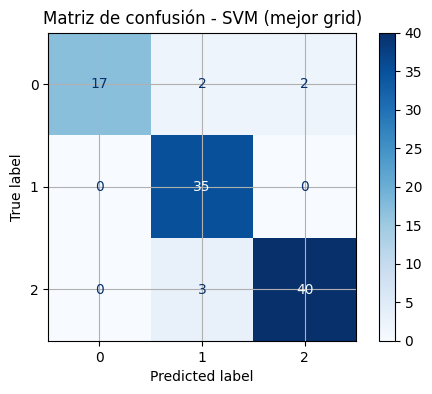

In [21]:
# Validación modelo SVM de la Etapa 1
# Cargar el pipeline de la etapa 1 y predecir en nuevos datos de prueba
pipeline = joblib.load("docs/svm_pipeline.joblib")
print("Pipeline cargado exitosamente.")

X_test = df_validacion["textos"].astype(str)
y_test = df_validacion["labels"]
y_pred = pipeline.predict(X_test)

print("\n SVM (etapa 1 sin balanceo) en nuevos datos de prueba \n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - SVM (mejor grid)")
plt.show()

Pipeline cargado exitosamente.

 SVM (etapa 2 con balanceo) en nuevos datos de prueba 

              precision    recall  f1-score   support

           1      1.000     0.810     0.895        21
           3      0.833     1.000     0.909        35
           4      0.975     0.907     0.940        43

    accuracy                          0.919        99
   macro avg      0.936     0.906     0.915        99
weighted avg      0.930     0.919     0.919        99



C:\Users\Lila\AppData\Local\Temp\ipykernel_40696\2574022093.py:18: DeprecationWarning: 'count' is passed as positional argument
  doc = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚ\s]', '', doc, re.I|re.A)


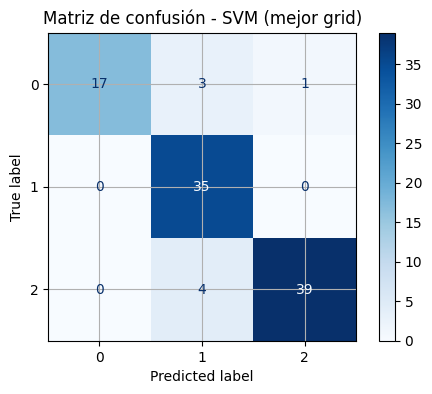

In [22]:
# Validación modelo SVM de la Etapa 2
# Cargar el pipeline de la etapa 2 y predecir en nuevos datos de prueba
pipeline = joblib.load("docs/svm_pipeline_etapa2.joblib")
print("Pipeline cargado exitosamente.")

X_test = df_validacion["textos"].astype(str)
y_test = df_validacion["labels"]
y_pred = pipeline.predict(X_test)

print("\n SVM (etapa 2 con balanceo) en nuevos datos de prueba \n")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[1,3,4])
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Matriz de confusión - SVM (mejor grid)")
plt.show()